<a href="https://colab.research.google.com/github/JonCrook/icl-ml-portfolio/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Introduction

**Context:**\
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

**Content:**\
The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.\
It contains only numerical input variables which are the result of a Principle Component Analysis transformation (dimensionality reduction technique).\
Due to confidentiality issues, the original features and more background information about the data cannot be provided.
Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.

> - Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.
- Feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning.
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

The model will be a Random Forest Classifier As this is a classification problem well suited to this approach. Bayesian Optimisation will be used to tune the model's hyperparameters

# 2.SetUp
First import the necessary libraries and load the fraud data

## 2.1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, get_scorer_names
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from timeit import default_timer as timer
!pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
!pip install hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Set random number for repeatability
random_state = 11

## 2.2 Import Data

In [3]:
# Mount Google drive as using colab - change if loading from different location
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/ColabData/'

Mounted at /content/drive


In [73]:
df_original = pd.read_csv(file_path + "creditcard.csv")
# Check what the data looks like
df_original.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 3.Data Analysis

## 3.1 Data Exploration
Undertake some initial exploratory feature analysis to get to know the data, find any missing values and look at the target class imbalance

In [74]:
# Number of Rows & Columns
df_original.shape

(284807, 31)

In [6]:
# Column Names and datatypes
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
# Basic Stats
df_original.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 3.2 Missing Values

In [8]:
# Check for columns with NaN values
df_original.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [9]:
# See how many rows have a NaN
df_original[df_original.isnull().any(axis=1)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


In [10]:
# none so no need to drop any rows
#df = df.dropna()
#df = df.reset_index(drop=True)
#df.shape

## 3.3 Target Class Imbalance

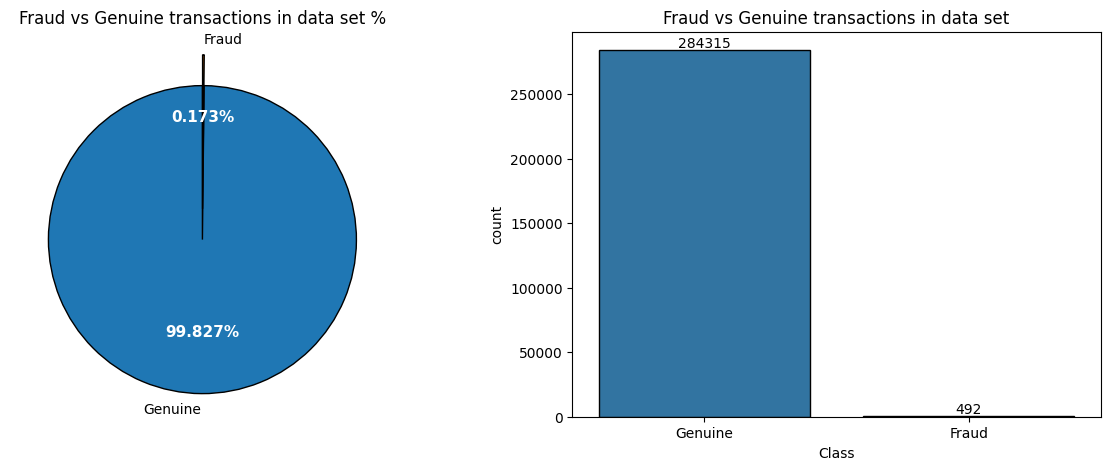

In [11]:
# Show the imbalance in the target variable 'Class'

class_counts = list(df_original['Class'].value_counts())
pie_values = [class_counts[0] / sum(class_counts) * 100, class_counts[1] / sum(class_counts) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

plt.subplot(1,2,1)
_, _, autopcts = plt.pie(pie_values,labels = ['Genuine','Fraud'], 
        autopct = '%1.3f%%',
        startangle = 90,
        explode = (0.1,0.1),
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('Fraud vs Genuine transactions in data set %');

plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':11})

plt.subplot(1,2,2)
ax = sns.countplot(data = df_original, 
                   x='Class', 
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['Genuine','Fraud'])
    
plt.title('Fraud vs Genuine transactions in data set')
plt.show()
plt.close()

## 3.4 Feature Correlation

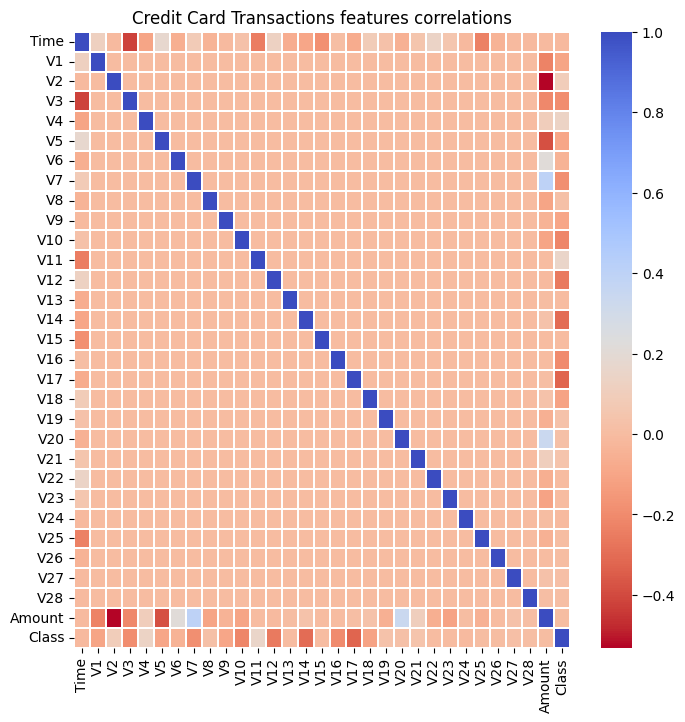

In [12]:
# Use a heatmap to show the correlation between the input variables
plt.figure(figsize = (8,8))
plt.title('Credit Card Transactions features correlations')
corr = df_original.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="coolwarm_r")
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

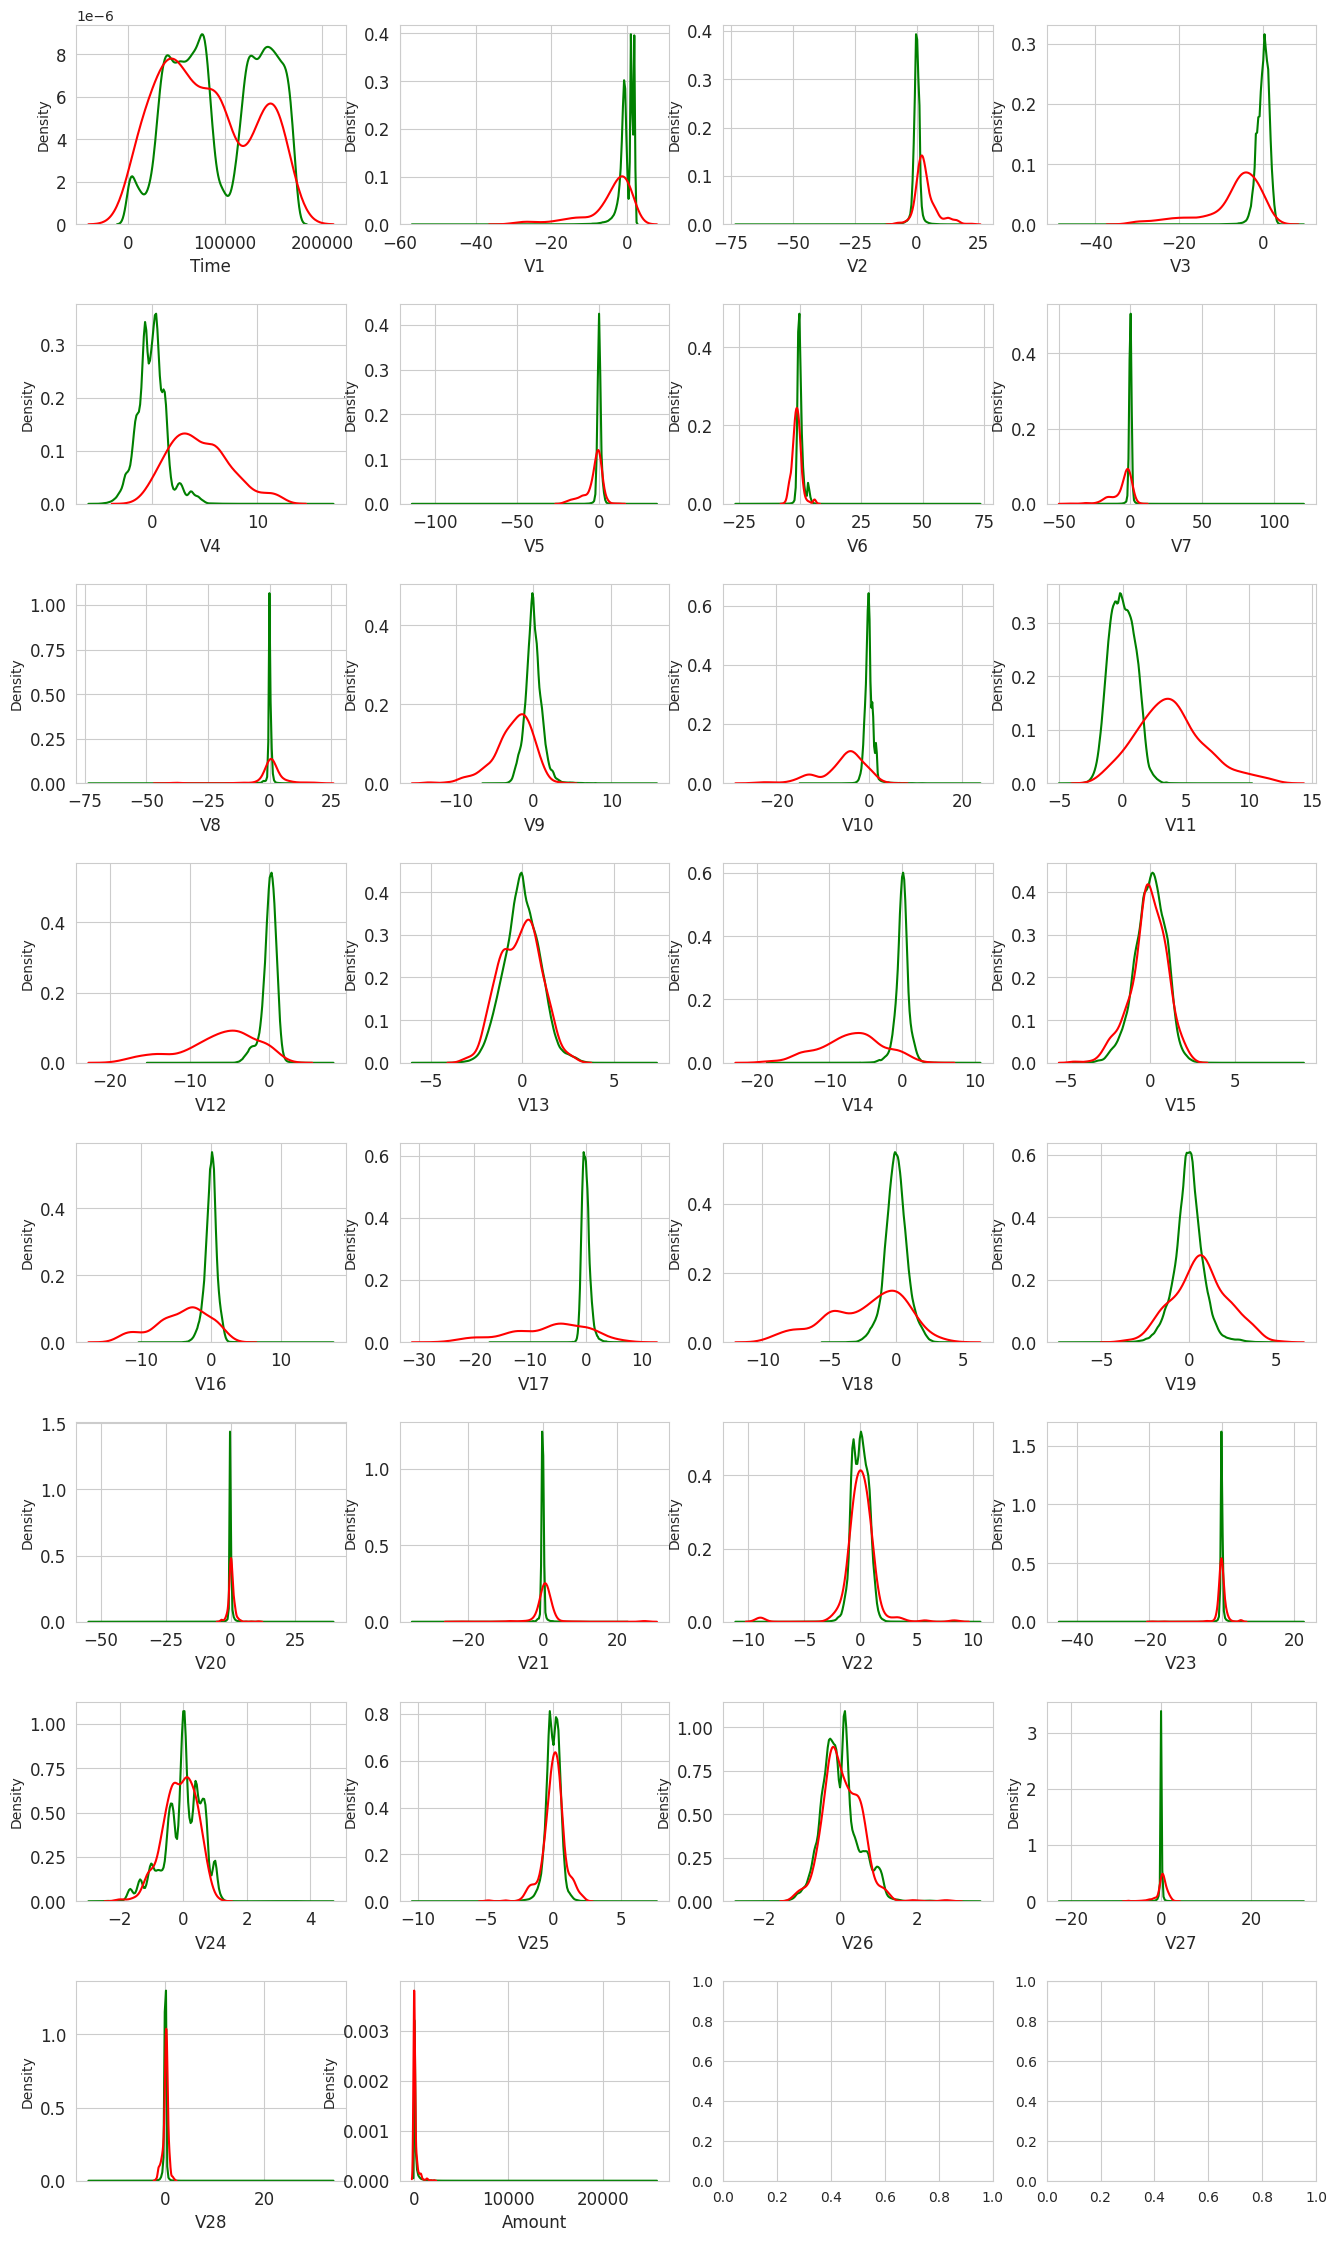

In [13]:
# Look at how each feature's distribution compares between fraud and genuine transactions
# Interested in features where the distributions diverge as this indicates a correlation 

# Remove the 'Class' feature as not plotting this
cols = np.delete(df_original.columns.values, np.where(df_original.columns.values == 'Class'))
i = 0
genuine = df_original.loc[df_original['Class'] == 0]
frauds = df_original.loc[df_original['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))
plt.subplots_adjust(hspace = 0.4)

for feature in cols:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(genuine[feature],label="0", color='green')
    sns.kdeplot(frauds[feature],label="1", color='red')
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();
plt.close()

A number of features show clear separation of distributions for the Class values 0 and 1. Those that are very similar and therefore have little impact on the class distinction could be dropped from the data to help simplify the model. Examples where the distribution are very similar and could be removed are: 
* V8,  V13,  V15,  V20,  V22,  V23,  V24,  V25,  V26,  V28,  Amount



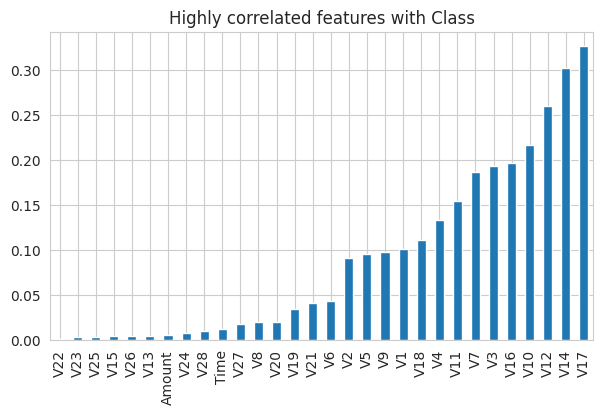

In [14]:
# Another way to look at correlation with the panda.dataframe.corr() method
plt.figure(figsize=(7,4))
d = df_original.corr()['Class'][:-1].abs().sort_values().plot(kind='bar',
                    title='Highly correlated features with Class')

The low correlation features match the info from the distribution curves

# 4.Train, Validation, Test Sets
Helper functions to help split the data into different datasets for building models

In [75]:
def build_test_datasets(data, validation_size=0.25, test_size=0.20):
  X = data.drop('Class', axis=1)
  y = data['Class']
  
  # First split the df into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True )

  # Then split the training set into train and validation
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state, shuffle=True )

  return X_train, y_train, X_val, y_val, X_test, y_test

def build_datasets(data, test_size=0.20):
  X = data.drop('Class', axis=1)
  y = data['Class']
  
  # Split the df into training and test sets
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True )

  return X_train, y_train, X_val, y_val

# 5.Random Forest Classifier

Initial model will be a Random Forest Classifier with standard parameters. Want to see how this performs before using additional techniques to improve the outcomes

In [76]:
# Create a helper list of the features
predictors = df_original.columns.to_list()
# But remove 'Class' as this is the target
predictors.pop(-1)

# Helper function to initialise the rfc model
def initialise_rfc(num_estimators=100, max_features='sqrt', max_depth=None):
  return RandomForestClassifier(n_jobs=4, # number of parallel jobs
                random_state=random_state,
                criterion='gini', # function to measure the quality of the split
                n_estimators=num_estimators, # number of trees in the forest
                max_features = max_features, # number of features to use at each split
                max_depth = max_depth, # max depth of the tree. If None then expanded until all leaves are pure
                verbose=False)

# Need to store the results in a dataframe with a brief description
results_df = pd.DataFrame(columns=['Desc', 'Precision', 'Recall', 'F1', 'AUPRC',
                                   'Reduced Features',
                                   'Outliers Removed',
                                   'Oversampled',
                                   'Undersampled',
                                   'Hyperparams Optimised'])

def add_to_results(desc, cr, auprc, reduced_features = False,
               outliers_removed = False,
               oversampled = False,
               undersampled = False,
               hyperparam_opt = False):
  new_row = [desc, round(cr['1']['precision'],3),
             round(cr['1']['recall'],3),
             round(cr['1']['f1-score'],3),
             round(auprc,3),
             reduced_features,
             outliers_removed,
             oversampled,
             undersampled,
             hyperparam_opt]

  results_df.loc[len(results_df)] = new_row
  return

In [77]:
# Let's create an intial Random Forest Classifier with standard hyperparameters

df = df_original.copy()
X_train, y_train, X_val, y_val, X_test, y_test = build_test_datasets(df)

start = timer()
# Initialise the model
clf = initialise_rfc()

# Train the RandomForestClassifier using the training data and fit function
clf.fit(X_train, y_train)

# Predict the target values for the validation data, using predict function
y_pred = clf.predict(X_val)

# Show the score (mean accuracy)
print('mean accuracy:',clf.score(X_val, y_val))

# Show how long this took to run
end = timer()
print('time taken:', end - start)

mean accuracy: 0.9996137776061234
time taken: 152.01679019599987


The model has a very high accuracy however this is not an ideal measure for data with a huge class imbalance.

For instance, if you have two classes, one with 99 data points and the other just 1, a naive model that always predicts the first class would be right 99% of the time. The model would score highly on accuracy, but it wouldn’t actually identify any examples of the smaller class.


## 5.1 Measuring Performance

Instead of accuracy we will use a number of other measures to understand the performance:

- **Precision** is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.

- **Recall** is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.

Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes as we have with the fraud data where there are many examples of no event (class 0) and only a few examples of an event (class 1).

The reason for this is that typically the large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives.

Key to the calculation of precision and recall is that the calculations do not make use of the true negatives. It is only concerned with the correct prediction of the minority class, class 1

- **F1 score** is a little less intuitive because it combines precision and recall into one metric. If precision and recall are both high, F1 will be high, too. If they are both low, F1 will be low. If one is high and the other low, F1 will be low. F1 is a quick way to tell whether the classifier is actually good at identifying members of a class, or if it is finding shortcuts (e.g., just identifying everything as a member of a large class).

- **Precision-Recall curves** summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.
ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.

The Kraggle datacard specifically recommends using the Area Under the Precision-Recall Curve (AUPRC) metric due to the class imbalance.
A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate

We will also use Confusion Matrices to get a quick, easy to interpret view of the predictive performance for the minority class.


[[56865     4]
 [   18    75]]


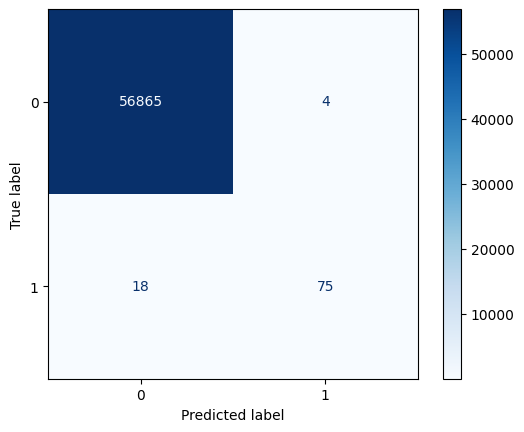

In [79]:
# In a Confusion Matrix:
# count of true negatives is {0,0}, false negatives is {1,0},
# true positives is {1,1} and false positives is {0,1}
cm = confusion_matrix(y_val, y_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

In [80]:
# The classification report shows the precision, recall and f1-score on the validation set
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56869
           1       0.95      0.81      0.87        93

    accuracy                           1.00     56962
   macro avg       0.97      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962



AUPRC: 0.8271263185117481


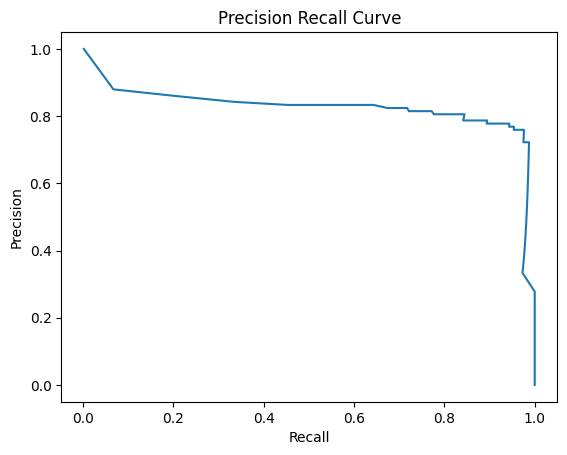

In [82]:
# Determine the Area Under the Precision-Recall Curve (AUPRC)

# Use the classifier to predict the probabilities of the test data
y_pred_prob = clf.predict_proba(X_test)[:,1]

# Calculate the precision-recall curve and the AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
auprc = auc(recall, precision)

# Print the AUPRC
print("AUPRC:", auprc)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

In [81]:
# Let's run this against the test dataset
def run_against_test(model, Xtest, ytest):

  y_pred = model.predict(Xtest)
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(ytest, y_pred))
  cr = classification_report(ytest, y_pred, output_dict=True)

  y_pred_prob = model.predict_proba(Xtest)[:,1]
  precision, recall, thresholds = precision_recall_curve(ytest, y_pred_prob)
  auprc = auc(recall, precision)
  
  # Print the AUPRC
  print("AUPRC:", auprc)

  return cr, auprc

In [83]:
cr, auprc = run_against_test(clf, X_test, y_test)

[[56849     5]
 [   25    83]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56854
           1       0.94      0.77      0.85       108

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC: 0.8271263185117481


In [84]:
# Record these initial results
add_to_results('1st run - basic RFC', cr, auprc,
               reduced_features = False,
               outliers_removed = False,
               oversampled = False,
               undersampled = False,
               hyperparam_opt = False)
print('class=1 fraud cases:', cr['1'])

class=1 fraud cases: {'precision': 0.9431818181818182, 'recall': 0.7685185185185185, 'f1-score': 0.8469387755102041, 'support': 108}


In [85]:
results_df

,Desc,Precision,Recall,F1,AUPRC,Reduced Features,Outliers Removed,Oversampled,Undersampled,Hyperparams Optimised
0,1st run - basic RFC,0.943,0.769,0.847,0.827,False,False,False,False,False


## 5.2 Remove Unimportant Features

Let's see if the model performs as well if we remove the features that have least importance


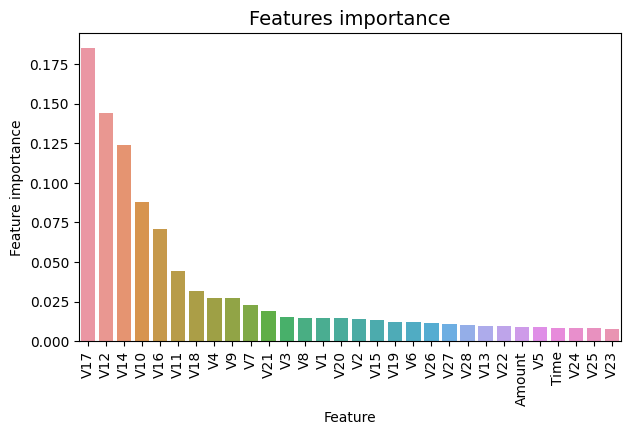

In [86]:
# Visualize the features importance
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

The most important features are V17, V12, V14, V10, V16

Potentially remove 'V3','V8','V1','V20','V2','V15','V19','V6','V26','V27','V28','V13','V22','Amount','V5','Time','V24','V25','V23'

Attempt 2 with a lower cut off point. Remove 'V19','V6','V26','V27','V28','V13','V22','Amount','V5','Time','V24','V25','V23'

Remember the unimportant features from the earlier analysis of distribution curves were:

V8, V13, V15, V20, V22, V23, V24, V25, V26, V28, Amount

So we are consistently seeing these features having low importance.

In [87]:
# So let's remove a number of low importance features and check performance.
# We would also expect the model to run in a faster time as there is lower dimensionality.
reduced_df = df_original.copy()
reduced_df = reduced_df.drop(['V3','V8','V1','V20','V2','V15','V19','V6','V26',
                    'V27','V28','V13','V22','Amount','V5','Time','V24','V25','V23'], axis=1)


In [88]:
start = timer()

# Build data sets
X_train, y_train, X_val, y_val, X_test, y_test = build_test_datasets(reduced_df)

# Initialise the model
#reduced_clf = initialise_rfc(num_estimators=100, max_features=5, max_depth=None)
reduced_clf = initialise_rfc()

# Train the RandomForestClassifier using the training data and fit function
reduced_clf.fit(X_train, y_train)

# Predict the target values for the validation data, using predict function
y_pred = reduced_clf.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

end = timer()
print('time taken:', end - start)

[[56865     4]
 [   19    74]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56869
           1       0.95      0.80      0.87        93

    accuracy                           1.00     56962
   macro avg       0.97      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

time taken: 91.27798940299999


Against the validation set this completed in ~60% of the time vs the full set of features. Small loss of performance with 1 correct prediction now showing as an additional false negative.

In [90]:
# Run against the test set and record the results
cr, auprc = run_against_test(reduced_clf, X_test, y_test)

add_to_results('2nd run - Reduced Features', cr, auprc,
               reduced_features = True,
               outliers_removed = False,
               oversampled = False,
               undersampled = False,
               hyperparam_opt = False)

[[56846     8]
 [   25    83]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56854
           1       0.91      0.77      0.83       108

    accuracy                           1.00     56962
   macro avg       0.96      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC: 0.8158858900061399


In [91]:
results_df

,Desc,Precision,Recall,F1,AUPRC,Reduced Features,Outliers Removed,Oversampled,Undersampled,Hyperparams Optimised
0,1st run - basic RFC,0.943,0.769,0.847,0.827,False,False,False,False,False
1,2nd run - Reduced Features,0.912,0.769,0.834,0.816,True,False,False,False,False


## 5.3 Cross Validation

Let's run cross-validation as an additional measure of performance.

Cross-validation is a technique for evaluating ML models by training on subsets of the available input data and evaluating them on the complementary subset of the data. It is useful for detecting overfitting.

In [76]:
# Just split the df into train and test as we are doing cross validation
X_train, y_train, X_test, y_test = build_datasets(reduced_df)

# Initialise the model
reduced_clf = initialise_rfc()

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

start = timer()
scores = cross_validate(reduced_clf, X_train, y_train, cv=5, scoring=scoring)
for metric, values in scores.items():
    print(f"{metric}: {values.mean():.3f} (+/- {values.std():.3f})")

end = timer()
print('time taken:', end - start)

fit_time: 106.168 (+/- 6.540)
score_time: 0.918 (+/- 0.212)
test_accuracy: 1.000 (+/- 0.000)
test_precision: 0.922 (+/- 0.011)
test_recall: 0.797 (+/- 0.050)
test_f1: 0.854 (+/- 0.028)
test_roc_auc: 0.951 (+/- 0.017)
time taken: 535.4657869399998


We can see from the accuracy and f1 scores the overfitting against the majority class

# 6.Working With an Imbalanced Dataset

As more of the transactions in the dataset are non-fraud we are getting overfitting of the models as they assume too many transactions are not fraud. We need to improve the predictive performance for detecting fraud transactions.

A number of techniques will be tested to try and improve performance:
- Additional scaling
- Oversampling
- Undersampling
- Detection and removal of outliers

Initially we will go back to the original full dataframe as there may be features whose correlation importance wasn't highlighted during the analysis of the unbalanced dataset that will now show with a balanced dataset.

## 6.1 Scaling 

First scale Amount and Time in the original dataframe as these are the only features that have yet to be scaled (the rest were scaled before generation of the Kaggle dataset during PCA).

In [92]:
# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler()

df_original['scaled_amount'] = rob_scaler.fit_transform(df_original['Amount'].values.reshape(-1,1))
df_original['scaled_time'] = rob_scaler.fit_transform(df_original['Time'].values.reshape(-1,1))

# Drop old columns
df_original.drop(['Time','Amount'], axis=1, inplace=True)

# Move to front of dataset
scaled_amount = df_original['scaled_amount']
scaled_time = df_original['scaled_time']

df_original.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df_original.insert(0, 'scaled_amount', scaled_amount)
df_original.insert(1, 'scaled_time', scaled_time)

df_original.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## 6.2 Create a Clean Test Set
Create a test set which remains in original condition so we are only applying changes to the training and validation sets. This means we can trust the results from the test set.

In [93]:
df = df_original.copy()
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class'], shuffle=True)
print(train_df.shape)
print(test_df.shape)
# check ratio of fraud vs genunie class counts
print(test_df['Class'].value_counts()/len(test_df))

(227845, 31)
(56962, 31)
0    0.99828
1    0.00172
Name: Class, dtype: float64


In [94]:
X_test = test_df.drop('Class', axis=1)
y_test = test_df['Class']

## 6.3 Undersampling

Undersampling is a technique to balance uneven datasets by keeping all of the data in the minority class (fraud) and decreasing the size of the majority class (non-fraud).

In [95]:
# Use undersampling to create a dataset with a 50/50 split of fraud vs non-fraud cases

# first shuffle the df
df = train_df.sample(frac=1, random_state=random_state)

fraud_df = df.loc[df['Class'] == 1]
genuine_df = df.loc[df['Class'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, genuine_df])

# Shuffle the new df
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
186696,-0.229861,0.499595,2.064407,-0.557448,-0.551933,-1.481870,-0.876825,-1.262291,-0.424510,-0.262442,...,-0.117888,-0.126656,-0.124101,0.335011,0.039766,-0.381868,-0.529742,0.036971,-0.034484,0
6331,-0.293440,-0.906566,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,...,0.488378,0.364514,-0.608057,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574,1
63634,1.089779,-0.398078,-9.169790,7.092197,-12.354037,4.243069,-7.176438,-3.386618,-8.058012,6.442909,...,0.816652,0.926157,-0.817706,-0.150434,-0.039383,0.485640,-0.264325,1.159690,0.232758,1
151196,7.678055,0.120537,0.842025,-0.365518,-2.464063,4.820886,0.775505,-0.614785,1.368024,-0.526262,...,0.944915,-0.110622,-1.257800,-0.324418,-0.420020,-0.219501,-0.268873,-0.144582,0.104464,1
204503,0.870258,0.594720,-3.158990,1.765452,-3.390168,0.987410,-1.509930,-1.280952,-2.719557,0.718325,...,-0.022590,1.120533,1.605085,-0.618637,-0.251283,-0.240528,-0.004327,-0.235477,0.018129,1


In [96]:
print(new_df.shape)
# check ratio of fraud vs genunie class counts
print(new_df['Class'].value_counts()/len(new_df))

(788, 31)
0    0.5
1    0.5
Name: Class, dtype: float64


Let's look again at which features influence whether a specific transaction is a fraud but using the new balanced dataset

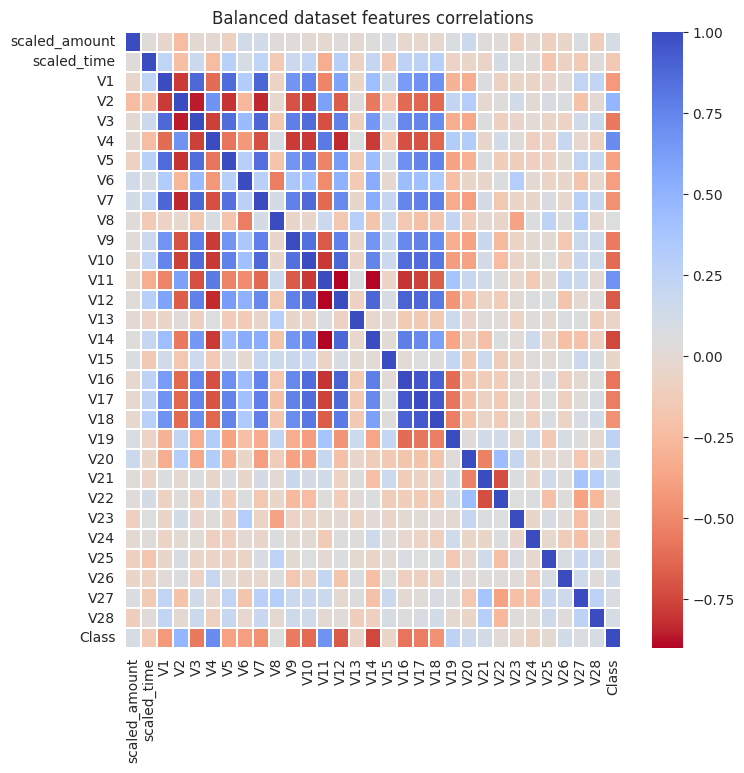

In [98]:
# Use a heatmap to show the correlation between the input variables
plt.figure(figsize = (8,8))
plt.title('Balanced dataset features correlations')
corr = new_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="coolwarm_r")
plt.show()
plt.close()

Very different pattern and a lot more correlation than shown with the unbalanced original dataset

V17, V14, V12 and V10 are most heavily negatively correlated. The lower values indicate higher likelihood to be a fraud.

Let's now use box plots to show the distribution:

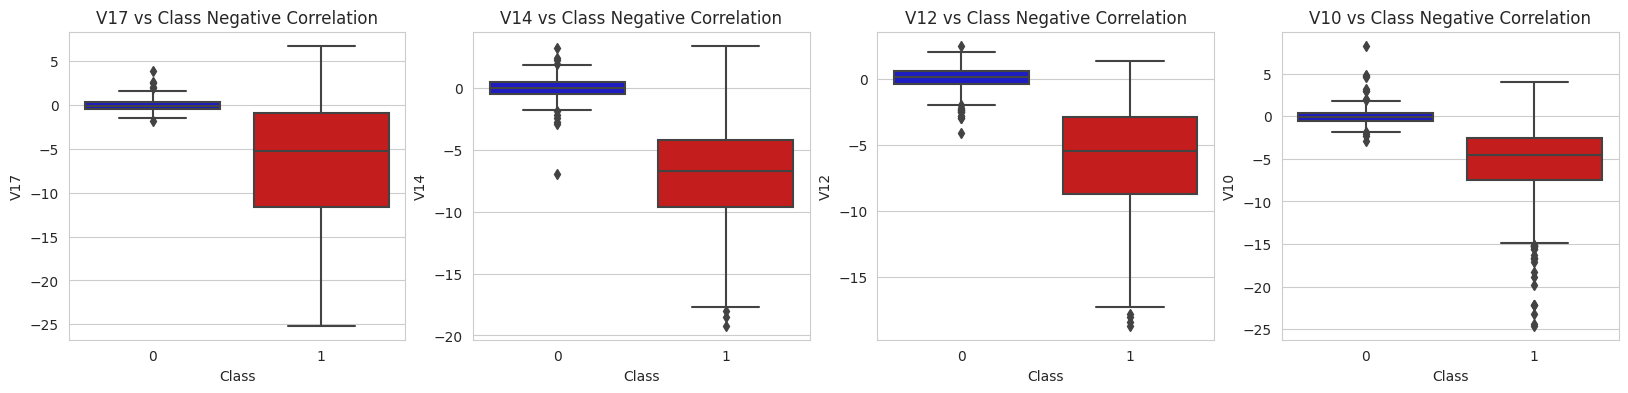

In [99]:
colors = ["#0101DF", "#DF0101"]

f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

Now for the non-fraud cases: V2, V4, V11, and V19 are most heavily positively correlated. The higher values indicate lower liklihood to be fraud

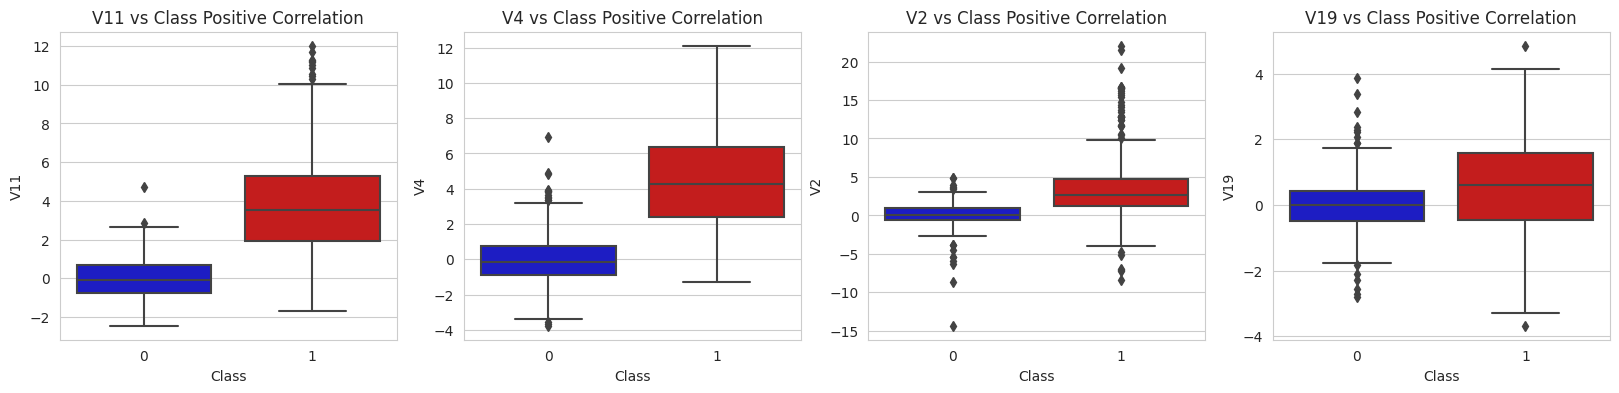

In [100]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

## 6.4 Detect & Remove Outliers

We will focus on removing outliers from those features that heavily influence the unbalanced fraud output class as this can help improve the model performance. These outliers can clearly be seen on the box plots above.

To help this we will use the Interquartile Range (IQR): Calculate this by the difference between the 75th percentile and 25th percentile. The aim is to create a threshold beyond the 75th and 25th percentile beyond which the instance will be deleted.

Outlier Removal Tradeoff:
Need to be careful in setting the threshold for removing outliers. We can determine the threshold by multiplying a number (ex: 1.5) by the Interquartile Range. The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect.



In [106]:
def detect_and_remove_outliers(dataf):
  
  threshold = 2.5
  #threshold = 1.5

  original_len = len(dataf)
  print('Starting number of Instances before outliers removal: {}'.format(original_len))

  # V14 Removing Outliers from fraud transactions (Highest Negative Correlation)
  v14_fraud = dataf['V14'].loc[dataf['Class'] == 1].values
  q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
  print('V14: Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
  v14_iqr = q75 - q25
  print('iqr: {}'.format(v14_iqr))

  v14_cut_off = v14_iqr * threshold
  v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
  print('Cut Off: {}'.format(v14_cut_off))
  print('V14 Lower: {}'.format(v14_lower))
  print('V14 Upper: {}'.format(v14_upper))

  outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
  print('V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
  print('V14 Outliers:{}'.format(outliers))

  dataf = dataf.drop(dataf[(dataf['V14'] > v14_upper) | (dataf['V14'] < v14_lower)].index)
  print('Number of V14 outliers removed: {}'.format(original_len - len(dataf)))
  print('----' * 20)

  # V12 removing outliers from fraud transactions
  v12_fraud = dataf['V12'].loc[dataf['Class'] == 1].values
  q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
  print('V12: Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
  v12_iqr = q75 - q25
  print('iqr: {}'.format(v12_iqr))

  v12_cut_off = v12_iqr * threshold
  v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
  print('Cut Off: {}'.format(v12_cut_off))
  print('V12 Lower: {}'.format(v12_lower))
  print('V12 Upper: {}'.format(v12_upper))

  outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
  print('V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
  print('V12 outliers: {}'.format(outliers))

  dataf = dataf.drop(dataf[(dataf['V12'] > v12_upper) | (dataf['V12'] < v12_lower)].index)
  print('Number of V12 outliers removed: {}'.format(original_len - len(dataf)))
  print('----' * 20)


  # V10 removing outliers from fraud transactions
  v10_fraud = dataf['V10'].loc[dataf['Class'] == 1].values
  q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
  print('V10: Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
  v10_iqr = q75 - q25
  print('iqr: {}'.format(v10_iqr))

  v10_cut_off = v10_iqr * threshold
  v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
  print('Cut Off: {}'.format(v10_cut_off))
  print('V10 Lower: {}'.format(v10_lower))
  print('V10 Upper: {}'.format(v10_upper))

  outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
  print('V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
  print('V10 outliers: {}'.format(outliers))
  
  dataf = dataf.drop(dataf[(dataf['V10'] > v10_upper) | (dataf['V10'] < v10_lower)].index)
  print('Number of V10 outliers removed: {}'.format(original_len - len(dataf)))

  return dataf

In [98]:
new_df = detect_and_remove_outliers(new_df)

Starting number of Instances before outliers removal: 788
V14: Quartile 25: -9.637518544049888 | Quartile 75: -4.221933342363385
iqr: 5.415585201686503
Cut Off: 8.123377802529754
V14 Lower: -17.760896346579642
V14 Upper: 3.9014444601663696
V14 Outliers for Fraud Cases: 3
V14 Outliers:[-19.2143254902614, -18.0499976898594, -18.4937733551053]
Number of V14 outliers removed: 3
--------------------------------------------------------------------------------
V12: Quartile 25: -8.666924290151634 | Quartile 75: -2.8194622292998
iqr: 5.847462060851834
Cut Off: 8.771193091277752
V12 Lower: -17.438117381429386
V12 Upper: 5.951730861977952
V12 Outliers for Fraud Cases: 3
V12 outliers: [-18.0475965708216, -18.4311310279993, -18.6837146333443]
Number of V12 outliers removed: 6
--------------------------------------------------------------------------------
V10: Quartile 25: -7.17941335288298 | Quartile 75: -2.4384199450662076
iqr: 4.740993407816772
Cut Off: 7.111490111725158
V10 Lower: -14.29090346

Now run the model again against the undersampled dataset with outliers removed

In [99]:
start = timer()

# Build data sets
X_train, y_train, X_val, y_val = build_datasets(new_df)

# Initialise the model
#clf = initialise_rfc(num_estimators=100, max_features=5, max_depth=None)
clf = initialise_rfc()

# Train the RandomForestClassifier using the training data and fit function
clf.fit(X_train, y_train)

# Predict the target values for the validation data, using predict function
y_pred = clf.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

end = timer()
print('time taken:', end - start)

[[75  1]
 [ 5 70]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        76
           1       0.99      0.93      0.96        75

    accuracy                           0.96       151
   macro avg       0.96      0.96      0.96       151
weighted avg       0.96      0.96      0.96       151

time taken: 0.38571817400043074


We have signficantly improved performance on the validation set and model runtime is now under a second

In [100]:
# Run against the test set and record the results
cr, auprc = run_against_test(clf, X_test, y_test)

add_to_results('3rd run - Undersampled RFC', cr, auprc,
               reduced_features = False,
               outliers_removed = True,
               oversampled = False,
               undersampled = True,
               hyperparam_opt = False)

[[54962  1902]
 [   10    88]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.04      0.90      0.08        98

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.53     56962
weighted avg       1.00      0.97      0.98     56962

AUPRC: 0.745568356305389


Recall is higher but can see that the precision, AUPRC and f1 scores are very low showing the undersampled model is massively overfitting.

However undersampling has enabled us to determine the key features that can be dropped which will help with Hyperparameter optimisation later on.

In [101]:
results_df

,Desc,Precision,Recall,F1,AUPRC,Reduced Features,Outliers Removed,Oversampled,Undersampled,Hyperparams Optimised
0,1st run - basic RFC,0.943,0.769,0.847,0.827,False,False,False,False,False
1,2nd run - Reduced Features,0.912,0.769,0.834,0.816,True,False,False,False,False
2,3rd run - Undersampled RFC,0.044,0.898,0.084,0.746,False,True,False,True,False


## 6.5 Oversampling
Random Oversampling involves supplementing the training data with multiple copies of some of the minority classes. Oversampling can be done more than once and has been proven to be robust for imbalanced datasets. Instead of duplicating every sample in the minority class, some of them may be randomly chosen with replacement

In [102]:
# Use the train df to resample and then split into train and test
df = train_df.copy()
X = df.drop('Class', axis=1)
y = df['Class']

ros = RandomOverSampler(random_state=random_state)

X_resampled, y_resampled = ros.fit_resample(X, y)

print(X.shape)
print(y.shape)
print(X_resampled.shape)
print(y_resampled.shape)
print(y_resampled.value_counts())

X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=random_state, shuffle=True )


(227845, 30)
(227845,)
(454902, 30)
(454902,)
0    227451
1    227451
Name: Class, dtype: int64


In [103]:
# See how the over sampled data performs in the model
# Initialise the model
#clf = initialise_rfc(num_estimators=100, max_features=5, max_depth=None)
clf = initialise_rfc()

# Train the RandomForestClassifier using the training data and fit function
clf.fit(X_train, y_train)

# Predict the target values for the validation data, using predict function
y_pred = clf.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

end = timer()
print('time taken:', end - start)

[[45488     4]
 [    0 45489]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45492
           1       1.00      1.00      1.00     45489

    accuracy                           1.00     90981
   macro avg       1.00      1.00      1.00     90981
weighted avg       1.00      1.00      1.00     90981

time taken: 248.43899654399956


So this has now correctly predicted all except 4 samples from the validation set

In [104]:
# Now predict the target values for the test data (that hasn't been oversampled) and record results
cr, auprc = run_against_test(clf, X_test, y_test)

add_to_results('4th run - Oversampled RFC', cr, auprc,
               reduced_features = False,
               outliers_removed = False,
               oversampled = True,
               undersampled = False,
               hyperparam_opt = False)

[[56859     5]
 [   21    77]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.79      0.86        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC: 0.8701277212537049


In [105]:
results_df

,Desc,Precision,Recall,F1,AUPRC,Reduced Features,Outliers Removed,Oversampled,Undersampled,Hyperparams Optimised
0,1st run - basic RFC,0.943,0.769,0.847,0.827,False,False,False,False,False
1,2nd run - Reduced Features,0.912,0.769,0.834,0.816,True,False,False,False,False
2,3rd run - Undersampled RFC,0.044,0.898,0.084,0.746,False,True,False,True,False
3,4th run - Oversampled RFC,0.939,0.786,0.856,0.870,False,False,True,False,False


Best performance so far on AUPRC!

## 6.6 Remove outliers and oversample again
We still have the outliers in so lets remove them and then oversample again to see if that changes performance

In [107]:
df = train_df.copy()
print(df.shape)
# changed threshold to 2.5 as catching too many datapoints @1.5
df = detect_and_remove_outliers(df)
print(df.shape)

(227845, 31)
Starting number of Instances before outliers removal: 227845
V14: Quartile 25: -9.637518544049888 | Quartile 75: -4.221933342363385
iqr: 5.415585201686503
Cut Off: 13.538963004216258
V14 Lower: -23.176481548266146
V14 Upper: 9.317029661852875
V14 Outliers for Fraud Cases: 0
V14 Outliers:[]
Number of V14 outliers removed: 1
--------------------------------------------------------------------------------
V12: Quartile 25: -8.681126399582094 | Quartile 75: -2.8261439751365973
iqr: 5.854982424445497
Cut Off: 14.637456061113742
V12 Lower: -23.318582460695836
V12 Upper: 11.811312085977145
V12 Outliers for Fraud Cases: 0
V12 outliers: []
Number of V12 outliers removed: 1
--------------------------------------------------------------------------------
V10: Quartile 25: -7.507696153510432 | Quartile 75: -2.500871434559355
iqr: 5.006824718951077
Cut Off: 12.517061797377693
V10 Lower: -20.024757950888123
V10 Upper: 10.016190362818339
V10 Outliers for Fraud Cases: 6
V10 outliers: [-24

In [108]:
X = df.drop('Class', axis=1)
y = df['Class']

ros = RandomOverSampler(random_state=random_state)

X_resampled, y_resampled = ros.fit_resample(X, y)

print(X.shape)
print(y.shape)
print(X_resampled.shape)
print(y_resampled.shape)
print(y_resampled.value_counts())



(227704, 30)
(227704,)
(454632, 30)
(454632,)
0    227316
1    227316
Name: Class, dtype: int64


In [109]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=random_state, shuffle=True )

In [110]:
# See how the over sampled data performs in the model
# Initialise the model
#clf = initialise_rfc(num_estimators=100, max_features=5, max_depth=None)
clf = initialise_rfc()

# Train the RandomForestClassifier using the training data and fit function
clf.fit(X_train, y_train)

# Predict the target values for the validation data, using predict function
y_pred = clf.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

end = timer()
print('time taken:', end - start)

[[45377     3]
 [    0 45547]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45380
           1       1.00      1.00      1.00     45547

    accuracy                           1.00     90927
   macro avg       1.00      1.00      1.00     90927
weighted avg       1.00      1.00      1.00     90927

time taken: 651.7615766549998


In [111]:
# Now predict the target values for the test data (that hasn't been oversampled) and record results
cr, auprc = run_against_test(clf, X_test, y_test)

add_to_results('5th run - Oversampled RFC', cr, auprc,
               reduced_features = False,
               outliers_removed = True,
               oversampled = True,
               undersampled = False,
               hyperparam_opt = False)

[[56860     4]
 [   19    79]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.81      0.87        98

    accuracy                           1.00     56962
   macro avg       0.98      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC: 0.8585791906317032


In [112]:
results_df

,Desc,Precision,Recall,F1,AUPRC,Reduced Features,Outliers Removed,Oversampled,Undersampled,Hyperparams Optimised
0,1st run - basic RFC,0.943,0.769,0.847,0.827,False,False,False,False,False
1,2nd run - Reduced Features,0.912,0.769,0.834,0.816,True,False,False,False,False
2,3rd run - Undersampled RFC,0.044,0.898,0.084,0.746,False,True,False,True,False
3,4th run - Oversampled RFC,0.939,0.786,0.856,0.870,False,False,True,False,False
4,5th run - Oversampled RFC,0.952,0.806,0.873,0.859,False,True,True,False,False


# 7.Hyperparameter Tuning
So far we have chosen model hyperparameters based on our judgment/experience. Below we will try and improve performance by using techniques to tune the model hyperparameters.

The main parameters used by a Random Forest Classifier are:

- criterion = the function used to evaluate the quality of a split.
- max_depth = maximum number of levels allowed in each tree.
- max_features = maximum number of features considered when splitting a node.
- min_samples_leaf = minimum number of samples which can be stored in a tree leaf.
- min_samples_split = minimum number of samples necessary in a node to cause node splitting.
- n_estimators = number of trees in the ensemble.
- bootstrap = Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.


Running optimisation can take a considerable amount of time (hours) so we will use the reduced features dataframe which has the features that have the least importance on the target class removed.

Reducing dimensionality will therefore speed up the hyperparameter optimisation process.

In [17]:
reduced_df = df_original.copy()
reduced_df = reduced_df.drop(['V3','V8','V1','V20','V2','V15','V19','V6','V26',
                    'V27','V28','V13','V22','V5','V24','V25','V23'], axis=1)

X_train, y_train, X_test, y_test = build_datasets(reduced_df)

## 7.1 Random Search

In Random Search, we create a grid of hyperparameters and train/test our model on just some random combination of these hyperparameters.

In [125]:
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [5],
               'max_features': ['auto', 'sqrt', 5],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [20]}

clf = initialise_rfc()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 10, 
                               cv = 4, verbose= 1, random_state= 101, n_jobs = -1)
model.fit(X_train, y_train)

y_pred = model.best_estimator_.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[[56631   233]
 [   11    87]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.27      0.89      0.42        98

    accuracy                           1.00     56962
   macro avg       0.64      0.94      0.71     56962
weighted avg       1.00      1.00      1.00     56962



In [126]:
# Show the best parameters from the Random search optimisation
print(model.best_params_)

{'n_estimators': 20, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 5, 'criterion': 'gini'}


In [119]:
# Initialise a model with the best params from the Random search
best_params = {
    'criterion': 'gini',
    'n_estimators': 20,
    'max_depth': 5,
    'max_features': 'sqrt',
    'min_samples_split': 7,
    'min_samples_leaf': 8,
    'bootstrap': False
}

clf = RandomForestClassifier(**best_params)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=8,
                       min_samples_split=7, n_estimators=20)

In [120]:
# Run against the test dataset and record results
cr, auprc = run_against_test(clf, X_test, y_test)

add_to_results('6th run - Random Opt', cr, auprc,
               reduced_features = True,
               outliers_removed = False,
               oversampled = False,
               undersampled = False,
               hyperparam_opt = 'Random')

[[56435   429]
 [   11    87]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.17      0.89      0.28        98

    accuracy                           0.99     56962
   macro avg       0.58      0.94      0.64     56962
weighted avg       1.00      0.99      0.99     56962

AUPRC: 0.7191340439984335


<ipython-input-76-3def87c1cddd>:39: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df.loc[len(results_df)] = new_row


In [121]:
results_df

,Desc,Precision,Recall,F1,AUPRC,Reduced Features,Outliers Removed,Oversampled,Undersampled,Hyperparams Optimised
0,1st run - basic RFC,0.943,0.769,0.847,0.827,False,False,False,False,False
1,2nd run - Reduced Features,0.912,0.769,0.834,0.816,True,False,False,False,False
2,3rd run - Undersampled RFC,0.044,0.898,0.084,0.746,False,True,False,True,False
3,4th run - Oversampled RFC,0.939,0.786,0.856,0.870,False,False,True,False,False
4,5th run - Oversampled RFC,0.952,0.806,0.873,0.859,False,True,True,False,False
5,6th run - Random Opt,0.169,0.888,0.283,0.719,True,False,False,False,Random


## 7.2 Grid Search

In Grid Search, we set up a grid of hyperparameters and train/test our model on each of the possible combinations. In order to choose the parameters to use in Grid Search, we can now look at which parameters worked best with Random Search and form a grid based on them to see if we can find a better combination.

Grid Search can be implemented in Python using scikit-learn GridSearchCV() function

In [128]:
grid_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [5],
               'max_features': ['auto', 'sqrt', 5],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [20]}

clf = initialise_rfc()
model = GridSearchCV(estimator = clf, param_grid = grid_search, 
                               cv = 4, verbose= 5, n_jobs = -1)
model.fit(X_train, y_train)

y_pred = model.best_estimator_.predict(X_test)


Fitting 4 folds for each of 54 candidates, totalling 216 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [129]:
# Show the best parameters from the Grid search optimisation
print(model.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 20}


In [122]:
# Initialise a model with the best params from the Grid search
best_params = {
    'criterion': 'gini',
    'n_estimators': 20,
    'max_depth': 5,
    'max_features': 'auto',
    'min_samples_split': 5,
    'min_samples_leaf': 8,
    'bootstrap': False
}

clf = RandomForestClassifier(**best_params)
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(bootstrap=False, max_depth=5, max_features='auto',
                       min_samples_leaf=8, min_samples_split=5,
                       n_estimators=20)

In [123]:
# Run against the test dataset and record results
cr, auprc = run_against_test(clf, X_test, y_test)

add_to_results('7th run - Grid Opt', cr, auprc,
               reduced_features = True,
               outliers_removed = False,
               oversampled = False,
               undersampled = False,
               hyperparam_opt = 'Grid')

[[56604   260]
 [   11    87]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.25      0.89      0.39        98

    accuracy                           1.00     56962
   macro avg       0.63      0.94      0.69     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC: 0.7749372820268909


## 7.3 Bayesian Optimization

Bayesian optimization is a technique for tuning the hyperparameters of a machine learning model. Hyperparameters are the configuration parameters that are not learned during the training process, but are set prior to training and can have a significant impact on the performance of the model.

In Bayesian optimization, we use a probabilistic model to guide the search for the optimal set of hyperparameters. The approach involves constructing a prior distribution over the hyperparameters and then iteratively refining this distribution based on the results of the model evaluations.

At each iteration, we select the next set of hyperparameters to evaluate based on an acquisition function, which balances the exploration of new areas of the hyperparameter space with the exploitation of promising regions. We then evaluate the model with these hyperparameters and update the probabilistic model to reflect the new information.

The advantage of Bayesian optimization over other techniques, such as grid search or random search, is that it can be more efficient in terms of the number of evaluations required to find the optimal set of hyperparameters. By incorporating prior knowledge and iteratively refining the probabilistic model, Bayesian optimization can quickly narrow down the search space and focus on the most promising regions.

Bayesian Optimization can be performed in Python using the Hyperopt library.

In Hyperopt, Bayesian Optimization can be implemented giving 3 three main parameters to the function fmin().

- Objective Function = defines the loss function to minimize. We are going to minimise the negative f1-score 
- Domain Space = defines the range of input values to test (in Bayesian Optimization this space creates a probability distribution for each of the used Hyperparameters).
- Optimization Algorithm = defines the search algorithm to use to select the best input values to use in each new iteration.
- Additionally, can also be defined in fmin() the maximum number of evaluations to perform.


Hyperopt is one of several automated hyperparameter tuning libraries using Bayesian optimization. These libraries differ in the algorithm used to both construct the surrogate (probability model) of the objective function and choose the next hyperparameters to evaluate in the objective function. Hyperopt uses the Tree Parzen Estimator (TPE). Other Python libraries include Spearmint, which uses a Gaussian process for the surrogate, and SMAC, which uses a random forest regression.

Hyperopt has a simple syntax for structuring an optimization problem which extends beyond hyperparameter tuning to any problem that involves minimizing a function.

**NOTE: BO has been run multiple times with different ranges for the hyperparameters. However below just showing the most efficient run**

In [108]:
# Define the search space for the hyperparameters
space = {
    'criterion': hp.choice('criterion', ['entropy', 'gini']),
    'n_estimators': hp.choice('n_estimators', range(10, 50)),
    'max_depth': hp.choice('max_depth', [None]),
    'max_features': hp.choice('max_features', range(2, 10)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 8)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 7)),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

# Define the objective function to minimize
def objective(params):
    clf = RandomForestClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1').mean()
    return -score

# Perform the hyperparameter optimization using Bayesian optimization
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best hyperparameters found
print(best)

100%|██████████| 50/50 [4:12:50<00:00, 303.42s/trial, best loss: -0.8571581164684613]
{'bootstrap': 1, 'criterion': 0, 'max_depth': 0, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 21}


{'bootstrap': 1, 'criterion': 0, 'max_depth': 0, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 21}

In [134]:
# Initialise a model with the best params from the BO
best_params = {
    'criterion': 'entropy',
    'n_estimators': 21,
    'max_depth': None,
    'max_features': 2,
    'min_samples_split': 3,
    'min_samples_leaf': 2,
    'bootstrap': False
}

clf = RandomForestClassifier(**best_params)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=2,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=21)

In [135]:
# Run against the test dataset and record results
cr, auprc = run_against_test(clf, X_test, y_test)

[[56860     4]
 [   20    78]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.80      0.87        98

    accuracy                           1.00     56962
   macro avg       0.98      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC: 0.8706244173365821


In [136]:
add_to_results('8th run - BO Opt', cr, auprc,
               reduced_features = True,
               outliers_removed = False,
               oversampled = False,
               undersampled = False,
               hyperparam_opt = 'BO')

# 8.Conclusion

Let's bring it all together to build the best model and show the results.

- Reduced Features = True
- Oversampling = True
- Outliers = False
- Hyperparameters optimised = True - Bayesian Optimisation

Hyperparameters are:
- criterion = entropy
- n_estimators = 21
- max_depth = None (nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples)
- max features = 2
- min_samples_split = 3
- min_samples_leaf = 2
- bootstrap = False

In [158]:
# Build a clean set of datasets
df = df_original.copy()
#df = df.drop(['V3','V8','V1','V20','V2','V15','V19','V6','V26',
#                    'V27','V28','V13','V22','V5','V24','V25','V23'], axis=1)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state, stratify=df['Class'], shuffle=True)

X_train = train_df.drop('Class', axis=1)
y_train = train_df['Class']
X_test = test_df.drop('Class', axis=1)
y_test = test_df['Class']

In [159]:
# Use random Oversampling
ros = RandomOverSampler(random_state=random_state)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print(X_train.shape)
print(y_train.shape)
print(X_resampled.shape)
print(y_resampled.shape)
print(y_resampled.value_counts())


(227845, 30)
(227845,)
(454902, 30)
(454902,)
0    227451
1    227451
Name: Class, dtype: int64


In [160]:
# Run the RFC with the best hyperparameters
best_params = {
    'criterion': 'entropy',
    'n_estimators': 21,
    'max_depth': None,
    'max_features': 2,
    'min_samples_split': 3,
    'min_samples_leaf': 2,
    'bootstrap': False
}

clf = RandomForestClassifier(**best_params)
clf.fit(X_resampled, y_resampled)

# Run against the test dataset and record results
cr, auprc = run_against_test(clf, X_test, y_test)

[[56859     5]
 [   17    81]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.83      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC: 0.889914106722515


In [144]:
add_to_results('9th run - Best Model', cr, auprc,
               reduced_features = True,
               outliers_removed = False,
               oversampled = True,
               undersampled = False,
               hyperparam_opt = 'BO')

AUPRC =  0.889914106722515


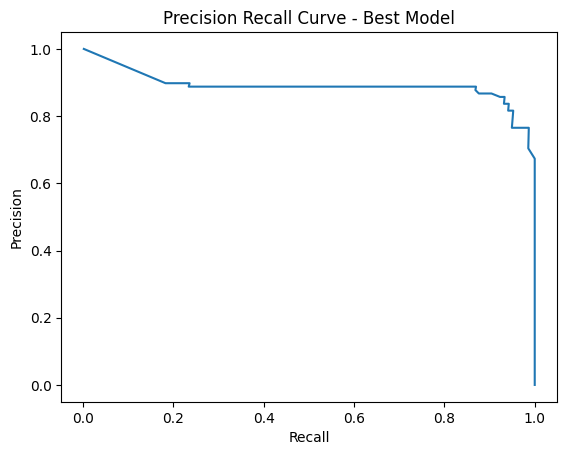

In [162]:
# Plot the final Precision Recall Curve
# Use the classifier to predict the probabilities of the test data
y_pred_prob = clf.predict_proba(X_test)[:,1]

# Calculate the precision-recall curve and the AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
auprc = auc(recall, precision)

# Print the AUPRC
print("AUPRC = ", auprc)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve - Best Model')
plt.show()

## 8.1 Final Results Dataframe

In [167]:
results_df

,Desc,Precision,Recall,F1,AUPRC,Reduced Features,Outliers Removed,Oversampled,Undersampled,Hyperparams Optimised
0,1st run - basic RFC,0.943,0.769,0.847,0.827,False,False,False,False,False
1,2nd run - Reduced Features,0.912,0.769,0.834,0.816,True,False,False,False,False
2,3rd run - Undersampled RFC,0.044,0.898,0.084,0.746,False,True,False,True,False
3,4th run - Oversampled RFC,0.939,0.786,0.856,0.870,False,False,True,False,False
4,5th run - Oversampled RFC,0.952,0.806,0.873,0.859,False,True,True,False,False
5,6th run - Random Opt,0.169,0.888,0.283,0.719,True,False,False,False,Random
6,7th run - Grid Opt,0.251,0.888,0.391,0.775,True,False,False,False,Grid
7,8th run - BO Opt,0.951,0.796,0.867,0.871,True,False,False,False,BO
8,9th run - Best Model,0.942,0.827,0.880,0.892,True,False,True,False,BO
